In [ ]:
import dataclasses
import pathlib

import cv2
import numpy as np
import PIL.Image
import torch
import tqdm
from rpg_e2vid.utils.inference_utils import events_to_voxel_grid
from rpg_e2vid.utils.loading_utils import load_model

import const
import utils

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
DATA_PATH = pathlib.Path("../data/raw/carla/") / "001-town01"
events_orig = np.load(DATA_PATH / "all_events_00000.npy")
bgr_frames = np.load(DATA_PATH / "bgr_frames_00000.npy")
bgr_timestamps = (np.load(DATA_PATH / "bgr_timestamps_00000.npy") * 1000).astype(
    np.int64
)
bgr_timestamps = bgr_timestamps - bgr_timestamps[0]

In [ ]:
events = np.stack(
    [events_orig["t"], events_orig["x"], events_orig["y"], events_orig["p"]]
).T.astype(np.int64)
event_timestamps = (events[:, 0] / 1e6).astype(np.int64)
event_timestamps = event_timestamps - event_timestamps[0]

In [ ]:
_, ts_counts = np.unique(event_timestamps, return_counts=True)

In [ ]:
model = load_model("../pretrained/E2VID_lightweight.pth.tar").to(const.DEVICE)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [ ]:
eit = utils.EventWindowIterator(events, ts_counts, 50, 50, 0)
prev = None
rec_frames = []
rec_ts = []
for (
    i,
    window,
) in tqdm.tqdm(enumerate(eit), total=len(eit)):
    rec_ts.append(window[-1, 0])
    window = window.copy()
    vg = events_to_voxel_grid(window, 5, 640, 480)
    vg = torch.from_numpy(vg).unsqueeze(0).float().to(const.DEVICE)
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
    pred_gb = cv2.GaussianBlur(pred, (0, 0), 3)
    pred = cv2.addWeighted(pred, 1.5, pred_gb, -0.5, 0)

    rec_frames.append(pred)

rec_ts = np.array(rec_ts)
rec_frames = np.stack(rec_frames)

100%|██████████| 500/500 [00:34<00:00, 14.30it/s]


In [ ]:
out = cv2.VideoWriter(
    "out.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (640, 480), isColor=False
)
for rec_frame in tqdm.tqdm(rec_frames):
    out.write(rec_frame)

out.release()

100%|██████████| 500/500 [00:00<00:00, 916.82it/s]


In [ ]:
exp_paths = list(pathlib.Path("../data/processed/carla/").glob("*.npy"))
len(exp_paths)

166

In [ ]:
def export_frames(
    src_frames: utils.Frames,
    events: np.ndarray,
    ts_counts: np.ndarray,
    model: torch.nn.Module,
    skip_every: int = 3,
) -> np.ndarray:
    count_index = 0
    event_index = 0
    prev = None
    results = []
    for i in tqdm.tqdm(range(1, src_frames.num_frames), desc="Overlaying frames"):
        if src_frames.timestamps[i] == 0:
            continue
        window_start = src_frames.timestamps[i - 1]
        window_end = src_frames.timestamps[i]
        events_in_window = ts_counts[window_start:window_end].sum()
        events_end = event_index + events_in_window
        window = events[event_index:events_end].copy()
        count_index += src_frames.timestamps[i]
        event_index = events_end
        if not len(window):
            break

        voxel_grid = events_to_voxel_grid(
            window, 5, src_frames.width, src_frames.height
        )
        voxel_grid = torch.from_numpy(voxel_grid).to(const.DEVICE).unsqueeze(0).float()
        with torch.no_grad():
            pred, prev = model(voxel_grid, prev)
            pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)

        pred = pred[..., np.newaxis]
        if skip_every > 0 and i % skip_every != 0:
            continue

        # pred_gb = cv2.GaussianBlur(pred, (0, 0), 3)
        # pred = cv2.addWeighted(pred, 1.5, pred_gb, -0.5, 0)[..., np.newaxis]

        src_frame = src_frames.array[i]
        frame = np.concatenate([src_frame, pred], axis=-1)
        results.append(frame)
    return np.stack(results)

In [ ]:
bgr_frames_obj = utils.Frames(
    np.stack(
        [
            cv2.cvtColor(cv2.resize(frame, (640, 480)), cv2.COLOR_BGR2RGB)
            for frame in bgr_frames
        ]
    ),
    bgr_timestamps,
)

In [ ]:
rec_frames = export_frames(bgr_frames_obj, events, ts_counts, model)

Overlaying frames: 100%|██████████| 499/499 [00:33<00:00, 14.81it/s]


In [ ]:
ts_counts.sum()

np.int64(75612247)

In [ ]:
bgr_frames_obj.timestamps.sum()

np.int64(6249975)

In [ ]:
bgr_frames_obj.array.sum()

np.uint64(69952666199)

In [ ]:
events

array([[154977956326,           23,          273,            1],
       [154977966939,           24,          274,            1],
       [154977971500,           24,          272,            1],
       ...,
       [179976223993,          624,          250,            1],
       [179976223993,          525,          256,            1],
       [179976223993,          623,          251,            0]])

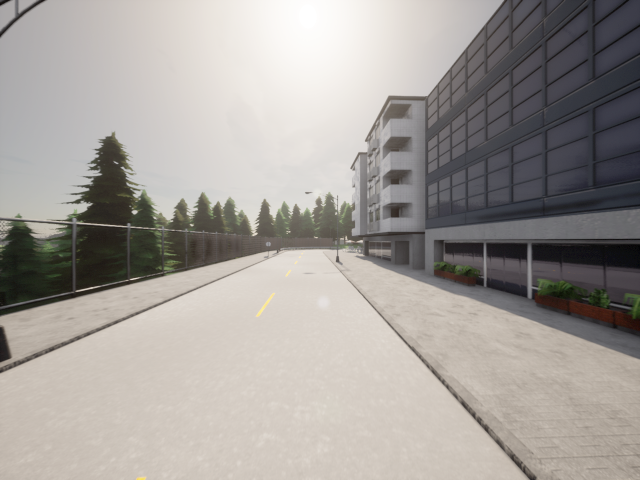

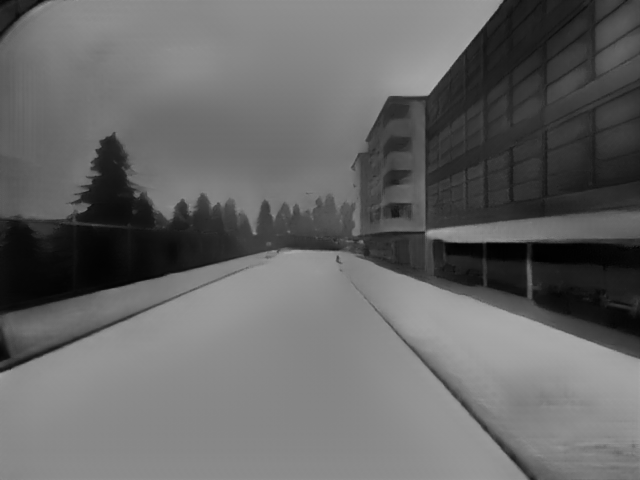

In [ ]:
showarray(rec_frames[10][..., :3])

showarray(rec_frames[10][..., 3])

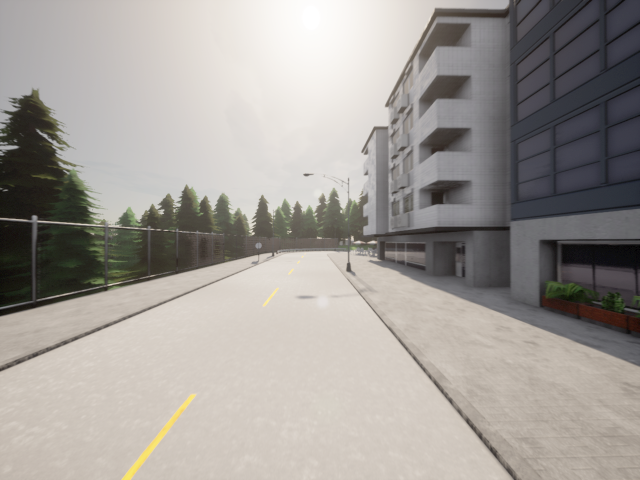

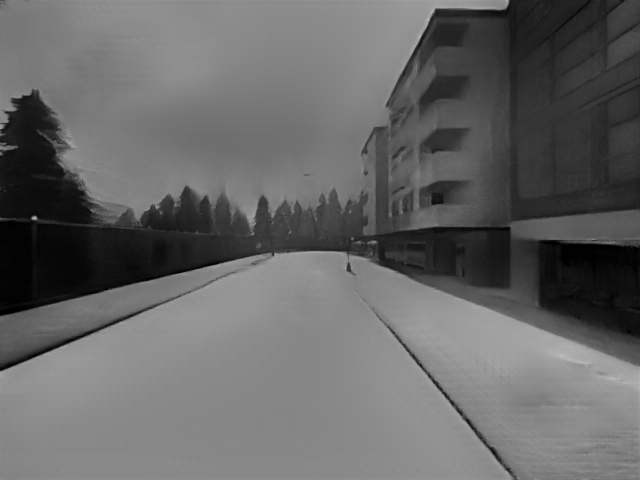

In [143]:
for p in exp_paths[20:]:
    exp = np.load(p)
    showarray(exp[..., :3])
    showarray(exp[..., 3])
    break